In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install category_encoders
!wget https://raw.githubusercontent.com/gustavovargas/tfm_afi/master/utils.py
!pip install lime

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from utils import LoansTransformer
import category_encoders as ce

from lime.lime_tabular import LimeTabularExplainer
from utils import LimeFormat
from functools import partial

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense 
from keras.layers.core import Activation

from keras.layers import Input, Add, LeakyReLU, BatchNormalization
from keras.models import Model, load_model

from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

In [0]:
x_train = joblib.load('/content/drive/My Drive/TFM/data/x_train.pkl').reset_index(drop=True)
x_test = joblib.load('/content/drive/My Drive/TFM/data/x_test.pkl').reset_index(drop=True)
y_train = joblib.load('/content/drive/My Drive/TFM/data/y_train.pkl').reset_index(drop=True)
y_test = joblib.load('/content/drive/My Drive/TFM/data/y_test.pkl').reset_index(drop=True)

In [0]:
x_train.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,16200.0,1,18.49,21,3,RENT,45000.0,Source Verified,102,debt_consolidation,GA,23.44,0.0,752,0.0,25.0,0.0,19531.0,57.6,48.0,1,16033.91,465.63,166.09,299.54,0.0,0.0,0.0,97,482.27,104,0.0,0.0
1,10000.0,0,19.52,18,10,RENT,40000.0,Not Verified,73,credit_card,FL,12.09,0.0,719,1.0,11.0,0.0,7169.0,62.9,14.0,1,0.00,8861.98,5625.67,3236.31,0.0,0.0,0.0,95,370.00,104,0.0,0.0
2,8300.0,0,16.99,17,10,RENT,32500.0,Not Verified,96,debt_consolidation,NJ,26.99,0.0,697,1.0,11.0,0.0,14660.0,57.0,19.0,1,6997.14,2063.33,1302.86,760.47,0.0,0.0,0.0,97,295.88,104,0.0,0.0
3,12000.0,1,9.99,7,7,OWN,70000.0,Source Verified,95,debt_consolidation,CA,27.14,0.0,370,0.0,11.0,1.0,6026.0,42.7,30.0,0,10723.18,2032.62,1276.82,755.80,0.0,0.0,0.0,97,254.91,104,0.0,0.0
4,4000.0,0,9.99,7,10,MORTGAGE,64000.0,Verified,100,major_purchase,NY,27.79,2.0,489,0.0,19.0,0.0,50000.0,27.2,36.0,0,3710.35,382.71,289.65,93.06,0.0,0.0,0.0,97,129.05,104,0.0,0.0


In [0]:
lt = joblib.load('/content/drive/My Drive/TFM/data/lt_transformer.pkl')

In [0]:
lt.categorical_features

['home_ownership', 'verification_status', 'purpose', 'addr_state']

In [0]:
preprocessor = ce.OneHotEncoder(cols = lt.categorical_features, return_df=True, handle_unknown="ignore")

In [0]:
column_names = preprocessor.fit_transform(x_train).columns.values

In [0]:
train = preprocessor.fit_transform(x_train)
train.shape

(577834, 103)

In [0]:
train.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,home_ownership_5,home_ownership_6,annual_inc,verification_status_1,verification_status_2,verification_status_3,issue_d,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12,purpose_13,purpose_14,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,addr_state_6,addr_state_7,addr_state_8,addr_state_9,addr_state_10,...,addr_state_34,addr_state_35,addr_state_36,addr_state_37,addr_state_38,addr_state_39,addr_state_40,addr_state_41,addr_state_42,addr_state_43,addr_state_44,addr_state_45,addr_state_46,addr_state_47,addr_state_48,addr_state_49,addr_state_50,addr_state_51,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,16200.0,1,18.49,21,3,1,0,0,0,0,0,45000.0,1,0,0,102,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.44,0.0,752,0.0,25.0,0.0,19531.0,57.6,48.0,1,16033.91,465.63,166.09,299.54,0.0,0.0,0.0,97,482.27,104,0.0,0.0
1,10000.0,0,19.52,18,10,1,0,0,0,0,0,40000.0,0,1,0,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.09,0.0,719,1.0,11.0,0.0,7169.0,62.9,14.0,1,0.00,8861.98,5625.67,3236.31,0.0,0.0,0.0,95,370.00,104,0.0,0.0
2,8300.0,0,16.99,17,10,1,0,0,0,0,0,32500.0,0,1,0,96,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.99,0.0,697,1.0,11.0,0.0,14660.0,57.0,19.0,1,6997.14,2063.33,1302.86,760.47,0.0,0.0,0.0,97,295.88,104,0.0,0.0
3,12000.0,1,9.99,7,7,0,1,0,0,0,0,70000.0,1,0,0,95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.14,0.0,370,0.0,11.0,1.0,6026.0,42.7,30.0,0,10723.18,2032.62,1276.82,755.80,0.0,0.0,0.0,97,254.91,104,0.0,0.0
4,4000.0,0,9.99,7,10,0,0,1,0,0,0,64000.0,0,0,1,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.79,2.0,489,0.0,19.0,0.0,50000.0,27.2,36.0,0,3710.35,382.71,289.65,93.06,0.0,0.0,0.0,97,129.05,104,0.0,0.0


In [0]:
test = preprocessor.transform(x_test)
test.shape

(247647, 103)

In [0]:
# Lo hacemos con Sequential porque tiene predict_proba y el Functional no.
# Necesitamos predcit_proba para usar Lime

model_2 = Sequential()

model_2.add(BatchNormalization(input_shape=(train.shape[1],)))
model_2.add(Dense(train.shape[1]))
model_2.add(LeakyReLU(alpha=0.1))

model_2.add(Dense(train.shape[1]))
model_2.add(LeakyReLU(alpha=0.1))

model_2.add(Dense(train.shape[1]))
model_2.add(LeakyReLU(alpha=0.1))

model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_2.fit(train,
                    y_train,
                    validation_split=0.20,
                    batch_size=1024,
                    epochs = 50,
                    verbose = 2)

score = model_2.evaluate(test, y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

Train on 462267 samples, validate on 115567 samples
Epoch 1/50
 - 5s - loss: 0.1356 - acc: 0.9590 - val_loss: 0.0892 - val_acc: 0.9746
Epoch 2/50
 - 4s - loss: 0.0771 - acc: 0.9784 - val_loss: 0.0706 - val_acc: 0.9814
Epoch 3/50
 - 4s - loss: 0.0666 - acc: 0.9815 - val_loss: 0.0646 - val_acc: 0.9824
Epoch 4/50
 - 4s - loss: 0.0622 - acc: 0.9829 - val_loss: 0.0629 - val_acc: 0.9829
Epoch 5/50
 - 4s - loss: 0.0602 - acc: 0.9835 - val_loss: 0.0610 - val_acc: 0.9837
Epoch 6/50
 - 4s - loss: 0.0592 - acc: 0.9838 - val_loss: 0.0611 - val_acc: 0.9838
Epoch 7/50
 - 4s - loss: 0.0579 - acc: 0.9842 - val_loss: 0.0599 - val_acc: 0.9841
Epoch 8/50
 - 4s - loss: 0.0570 - acc: 0.9846 - val_loss: 0.0611 - val_acc: 0.9832
Epoch 9/50
 - 4s - loss: 0.0565 - acc: 0.9847 - val_loss: 0.0586 - val_acc: 0.9844
Epoch 10/50
 - 4s - loss: 0.0557 - acc: 0.9850 - val_loss: 0.0574 - val_acc: 0.9849
Epoch 11/50
 - 4s - loss: 0.0551 - acc: 0.9851 - val_loss: 0.0568 - val_acc: 0.9850
Epoch 12/50
 - 4s - loss: 0.0552 

In [0]:
model_2.save('/content/drive/My Drive/TFM/data/model_2_loans.h5')

In [0]:
model_2 = load_model('/content/drive/My Drive/TFM/data/model_2_loans.h5')

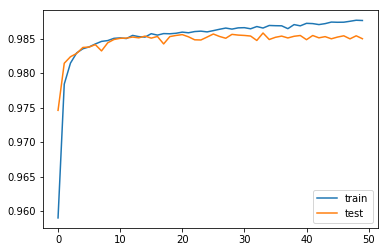

In [0]:
# plot history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

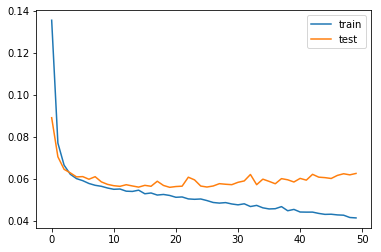

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Explicación con Lime


In [0]:
categorical_names = {}
for i in range(len(lt.le.mapping)):
    categorical_names[x_train.columns.get_loc(lt.le.mapping[i]['col'])] = np.array([j for j in lt.le.mapping[i]['mapping'].index[:-1]])
categorical_names

{5: array(['RENT', 'OWN', 'MORTGAGE', 'NONE', 'OTHER', 'ANY'], dtype='<U8'),
 7: array(['Source Verified', 'Not Verified', 'Verified'], dtype='<U15'),
 9: array(['debt_consolidation', 'credit_card', 'major_purchase',
        'small_business', 'car', 'other', 'home_improvement', 'medical',
        'vacation', 'moving', 'renewable_energy', 'house', 'wedding',
        'educational'], dtype='<U18'),
 10: array(['GA', 'FL', 'NJ', 'CA', 'NY', 'MI', 'TX', 'WA', 'CO', 'NC', 'CT',
        'NV', 'OH', 'AK', 'SC', 'IN', 'AL', 'MD', 'PA', 'LA', 'WI', 'MA',
        'DE', 'VA', 'AZ', 'MO', 'MN', 'AR', 'TN', 'KY', 'WY', 'UT', 'HI',
        'IL', 'NM', 'WV', 'VT', 'OK', 'OR', 'KS', 'MT', 'RI', 'NH', 'SD',
        'DC', 'MS', 'ME', 'NE', 'ID', 'ND', 'IA'], dtype='<U2')}

In [0]:
class_names = ['default', 'fully paid']

In [0]:
explainer = LimeTabularExplainer(LimeFormat(x_train, categorical_names).values,
                                 feature_names = x_train.columns.tolist(),
                                 class_names = class_names,
                                 categorical_names = categorical_names,
                                 categorical_features = categorical_names.keys(),
                                 discretize_continuous = True,
                                 random_state=42)

In [0]:
observation = lambda data, idx: LimeFormat(data.iloc[[idx]], categorical_names).values[0]

In [0]:
custom_predict_proba= lambda X, model: np.array([ [i, 1-i] for i in model.predict_proba(preprocessor.transform(LimeFormat(X, categorical_names, col_names=x_train.columns, invert=True)))[0]], dtype=np.float32)

In [0]:
explanation = lambda modelo, idx: explainer.explain_instance(observation(x_test, idx), partial(custom_predict_proba, model=modelo), num_features=5)

In [0]:
explanation(model_2, 16).show_in_notebook(show_all=True)

ValueError: ignored